Okay, let's build up Signal Detection Theory (SDT) models using PyMC step by step. This guide is designed to be didactic, explaining the concepts and the PyMC implementation as we go.

**Core Idea of SDT**

Signal Detection Theory helps us understand how we make decisions under uncertainty. Imagine trying to detect a faint signal amidst background noise. SDT quantifies two key aspects of this process:

1.  **Sensitivity (`d'`, d-prime):** How well can the observer distinguish the signal from the noise? This is related to the separation between the internal representations of noise and signal+noise. Higher `d'` means better sensitivity.
2.  **Criterion (`c`):** What is the observer's bias or threshold for deciding "signal"? A neutral criterion is `c=0`. A positive `c` means a conservative bias (needs strong evidence to say "signal", leading to fewer Hits but also fewer False Alarms). A negative `c` means a liberal bias (says "signal" readily, leading to more Hits but also more False Alarms).

**The Data**

SDT analysis typically uses counts from a task where stimuli are either "signal" or "noise", and the observer responds "yes" (signal present) or "no" (signal absent):

*   **Hits (H):** Responded "yes" when signal was present.
*   **Misses (M):** Responded "no" when signal was present.
*   **False Alarms (FA):** Responded "yes" when only noise was present.
*   **Correct Rejections (CR):** Responded "no" when only noise was present.

From these counts, we calculate rates:

*   **Hit Rate (HR):** `H / (H + M)` = P(Yes | Signal)
*   **False Alarm Rate (FAR):** `FA / (FA + CR)` = P(Yes | Noise)

**Linking Parameters to Data**

Assuming the internal representations of noise and signal+noise follow Gaussian distributions with equal variance, the rates are linked to `d'` and `c` via the cumulative distribution function (CDF) of the standard normal distribution (often denoted Φ or `pnorm`):

*   `HR = Φ(d'/2 - c)`
*   `FAR = Φ(-d'/2 - c)`

Our goal in PyMC is to estimate the posterior distributions of `d'` and `c` given the observed counts (H, M, FA, CR).

**Setup**

First, let's import the necessary libraries. We'll use PyMC for modeling, ArviZ for summarizing results, NumPy for numerical operations, and SciPy for the normal CDF function (although PyMC has its own).



In [31]:
import pymc as pm
import arviz as az
import numpy as np
import scipy.stats as stats
import pytensor.tensor as pt # For wrapping scipy functions if needed, or use pm.math

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

# Helper function for standard normal CDF (probit function inverse)
# PyMC provides pm.math.invprobit which is exactly this
def Phi(x):
  """Standard normal CDF"""
  # return 0.5 + 0.5 * pt.erf(x / pt.sqrt(2.)) # Alternative implementation
  return pm.math.invprobit(x) # Use PyMC's built-in function

# For plotting later
import matplotlib.pyplot as plt
import seaborn as sns


Running on PyMC v5.21.1
Running on ArviZ v0.21.0




---

## Model 1: Basic SDT (One Person, One Condition)

This is the simplest case. We have data from one observer performing the task under a single condition.

**1.1 Define Data**

Let's assume some hypothetical data:



In [32]:
# Data for one participant
hits = 75
misses = 25
false_alarms = 20
correct_rejections = 80

n_signal_trials = hits + misses
n_noise_trials = false_alarms + correct_rejections

print(f"N Signal Trials: {n_signal_trials}")
print(f"N Noise Trials: {n_noise_trials}")
print(f"Observed HR: {hits / n_signal_trials:.2f}")
print(f"Observed FAR: {false_alarms / n_noise_trials:.2f}")


N Signal Trials: 100
N Noise Trials: 100
Observed HR: 0.75
Observed FAR: 0.20




**1.2 Define the PyMC Model**

We'll define priors for `d'` and `c`. Normal distributions are common choices, often weakly informative (wide standard deviations) unless we have strong prior beliefs.



In [33]:
with pm.Model() as model_basic:
    # --- Priors ---
    # Sensitivity (d'). Normal prior, often centered at 0.
    # A standard deviation of 1.5 or 2 allows for a wide range of plausible values.
    d_prime = pm.Normal('d_prime', mu=0.0, sigma=2.0)

    # Criterion (c). Normal prior, also often centered at 0.
    criterion = pm.Normal('criterion', mu=0.0, sigma=2.0)

    # --- Deterministic Transformations ---
    # Calculate the theoretical Hit Rate and False Alarm Rate from d' and c
    # Using our Phi helper function (which uses pm.math.invprobit)
    hr_D = pm.Deterministic('hr_D', Phi(d_prime / 2 - criterion))
    far_D = pm.Deterministic('far_D', Phi(-d_prime / 2 - criterion))

    # --- Likelihood ---
    # The observed counts (Hits, False Alarms) follow Binomial distributions
    # conditioned on the number of trials and the theoretical rates (hr_D, far_D).

    # Likelihood for Hits (given signal trials)
    H_obs = pm.Binomial('H_obs',
                        n=n_signal_trials,
                        p=hr_D,
                        observed=hits)

    # Likelihood for False Alarms (given noise trials)
    FA_obs = pm.Binomial('FA_obs',
                         n=n_noise_trials,
                         p=far_D,
                         observed=false_alarms)




**Explanation:**

*   `pm.Model()` creates a context for our model.
*   `pm.Normal(...)`: Defines our prior beliefs about `d'` and `c`. We assume they could plausibly range around 0, with a standard deviation of 2 covering a wide range (e.g., 95% interval approx -4 to +4).
*   `pm.Deterministic(...)`: Calculates quantities derived from the model parameters (`d'`, `c`). We calculate the theoretical HR and FAR using the SDT formulas. Naming them with `_ D` is just a convention to easily identify deterministic nodes.
*   `pm.Binomial(...)`: This is the *likelihood* function. It connects our model parameters (via `hr_D`, `far_D`) to the observed data (`hits`, `false_alarms`). It says: "Given `n` trials and a probability `p` of success on each trial, what's the probability of observing `k` successes?". Here, 'success' means responding "yes".

**1.3 Run the Sampler (MCMC)**

Now we use PyMC's sampler (typically NUTS - No-U-Turn Sampler) to draw samples from the posterior distribution of `d'` and `c`.



In [34]:
with model_basic:
    # Draw samples from the posterior
    # `draws` = number of samples per chain after tuning
    # `tune` = number of steps to discard for tuning the sampler
    # `chains` = number of independent chains to run
    # `target_accept` = parameter for NUTS algorithm, higher values can help with difficult posteriors
    idata_basic = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d_prime, criterion]


/home/joachim/Dropbox/Teaching/S25/cogs107/0-introduction/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.




**1.4 Analyze Results**

We use ArviZ to check convergence and summarize the posterior distributions.



Basic SDT Model Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
d_prime    1.511  0.198   1.148    1.876      0.002    0.002    7232.0   
criterion  0.085  0.097  -0.102    0.264      0.001    0.001    7740.0   
hr_D       0.747  0.043   0.665    0.828      0.000    0.000    7717.0   
far_D      0.203  0.039   0.129    0.274      0.000    0.000    7108.0   

           ess_tail  r_hat  
d_prime      5381.0    1.0  
criterion    5566.0    1.0  
hr_D         5446.0    1.0  
far_D        5484.0    1.0  


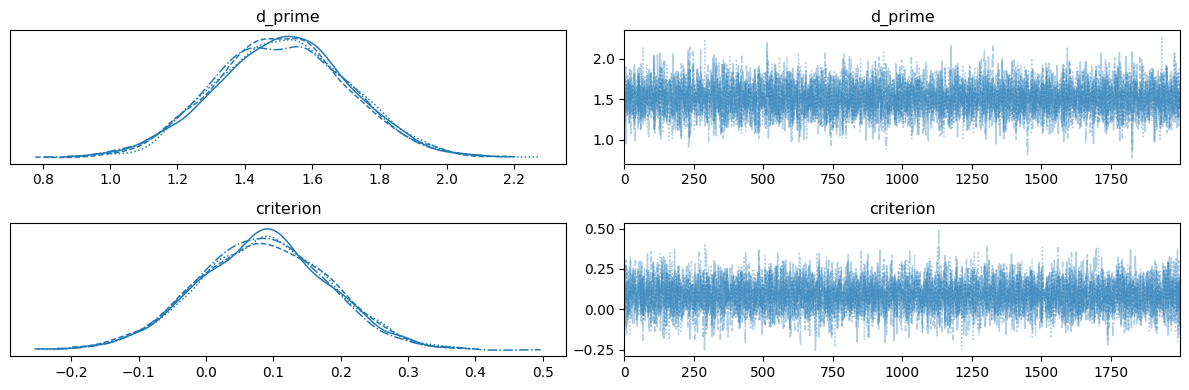

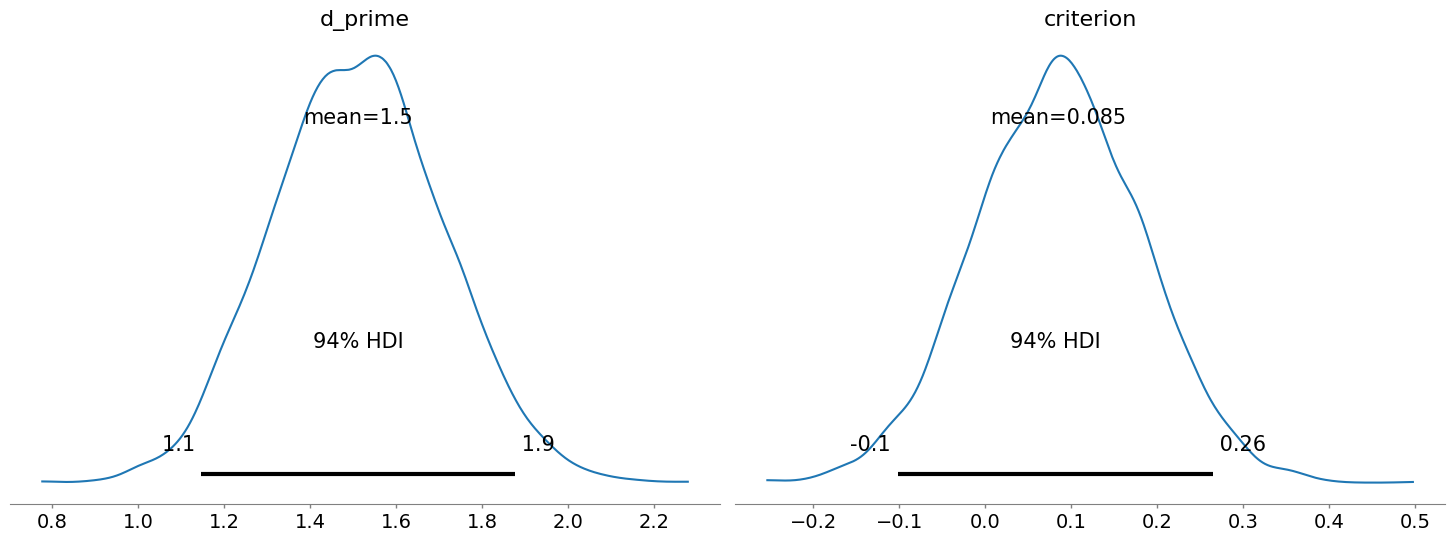

In [35]:
# Check summary statistics (mean, median, sd, credible intervals)
print("Basic SDT Model Summary:")
summary_basic = az.summary(idata_basic, var_names=['d_prime', 'criterion', 'hr_D', 'far_D'])
print(summary_basic)

# Check trace plots for convergence diagnostics
az.plot_trace(idata_basic, var_names=['d_prime', 'criterion'])
plt.tight_layout()
plt.show()

# Plot posterior distributions
az.plot_posterior(idata_basic, var_names=['d_prime', 'criterion'])
plt.tight_layout()
plt.show()




**Interpretation:**

The summary table gives us the mean, standard deviation, and credible intervals (e.g., 94% Highest Density Interval by default) for `d'` and `c`. The trace plots help us visually assess if the MCMC chains converged properly (they should look like "fuzzy caterpillars"). The posterior plots show the probability distribution of our estimated parameters after considering the data.

---

## Model 2: Conditional SDT (One Person, K Conditions)

Now, let's extend the model to handle data from one person across multiple experimental conditions (e.g., different stimulus difficulties, different payoffs). We expect `d'` or `c` (or both) might vary across conditions.

**2.1 Define Data**

Assume K=3 conditions. We need data for each.



In [36]:
# Data for one participant across K=3 conditions
conditions = ['Easy', 'Medium', 'Hard']
K = len(conditions)

# Hits for each condition
hits_k = np.array([90, 75, 60])
# Misses for each condition
misses_k = np.array([10, 25, 40])
# False Alarms for each condition
fas_k = np.array([10, 20, 25])
# Correct Rejections for each condition
crs_k = np.array([90, 80, 75])

# Calculate trials per condition
n_signal_trials_k = hits_k + misses_k
n_noise_trials_k = fas_k + crs_k

print(f"Conditions: {conditions}")
print(f"N Signal Trials per condition: {n_signal_trials_k}")
print(f"N Noise Trials per condition: {n_noise_trials_k}")


Conditions: ['Easy', 'Medium', 'Hard']
N Signal Trials per condition: [100 100 100]
N Noise Trials per condition: [100 100 100]




**2.2 Define the PyMC Model**

We'll estimate separate `d'` and `c` values for each condition. PyMC makes this easy using the `shape` argument.



In [37]:
coords = {"condition": conditions}

with pm.Model(coords=coords) as model_conditional:
    # --- Priors ---
    # We now estimate K values for d' and c, one for each condition.
    # The priors are the same type as before, but now define K independent parameters.
    # Use the `dims` argument to link the parameters to the coordinate names.
    d_prime = pm.Normal('d_prime', mu=0.0, sigma=2.0, dims="condition")
    criterion = pm.Normal('criterion', mu=0.0, sigma=2.0, dims="condition")

    # --- Deterministic Transformations ---
    # These calculations are now vectorized over the conditions.
    hr_D = pm.Deterministic('hr_D', Phi(d_prime / 2 - criterion), dims="condition")
    far_D = pm.Deterministic('far_D', Phi(-d_prime / 2 - criterion), dims="condition")

    # --- Likelihood ---
    # The observed counts are also vectors, one element per condition.
    # The likelihood is applied element-wise.
    H_obs = pm.Binomial('H_obs',
                        n=n_signal_trials_k, # Vector of N_signal trials
                        p=hr_D,             # Vector of hit rates
                        observed=hits_k,     # Vector of observed hits
                        dims="condition")

    FA_obs = pm.Binomial('FA_obs',
                         n=n_noise_trials_k, # Vector of N_noise trials
                         p=far_D,            # Vector of false alarm rates
                         observed=fas_k,      # Vector of observed false alarms
                         dims="condition")




**Explanation:**

*   `coords`: We define coordinates for our dimensions. This helps keep track of which index corresponds to which condition and makes plotting with ArviZ much nicer.
*   `dims="condition"`: We link the parameters and likelihoods to the 'condition' dimension defined in `coords`. This tells PyMC and ArviZ that these variables have multiple elements corresponding to the conditions.
*   `shape=K` (implicitly handled by `dims`): By specifying `dims`, PyMC knows to create `K` independent parameters for `d_prime` and `criterion`.
*   Vectorization: Notice how the inputs to `pm.Binomial` (`n`, `observed`) and its probability `p` (`hr_D`, `far_D`) are now NumPy arrays (or PyTensor vectors internally). PyMC automatically applies the likelihood calculation element-wise for each condition.

**2.3 Run the Sampler**



In [38]:
with model_conditional:
    idata_conditional = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d_prime, criterion]


/home/joachim/Dropbox/Teaching/S25/cogs107/0-introduction/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.




**2.4 Analyze Results**




Conditional SDT Model Summary:
                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
d_prime[Easy]      2.546  0.237   2.081    2.973      0.002    0.003   
d_prime[Medium]    1.507  0.200   1.131    1.878      0.002    0.002   
d_prime[Hard]      0.921  0.189   0.591    1.300      0.002    0.002   
criterion[Easy]    0.000  0.121  -0.231    0.223      0.001    0.001   
criterion[Medium]  0.082  0.101  -0.112    0.266      0.001    0.001   
criterion[Hard]    0.210  0.093   0.034    0.380      0.001    0.001   

                   ess_bulk  ess_tail  r_hat  
d_prime[Easy]       11222.0    6210.0    1.0  
d_prime[Medium]     11125.0    6130.0    1.0  
d_prime[Hard]       10712.0    5722.0    1.0  
criterion[Easy]     10145.0    6103.0    1.0  
criterion[Medium]   11236.0    5822.0    1.0  
criterion[Hard]     11409.0    6121.0    1.0  


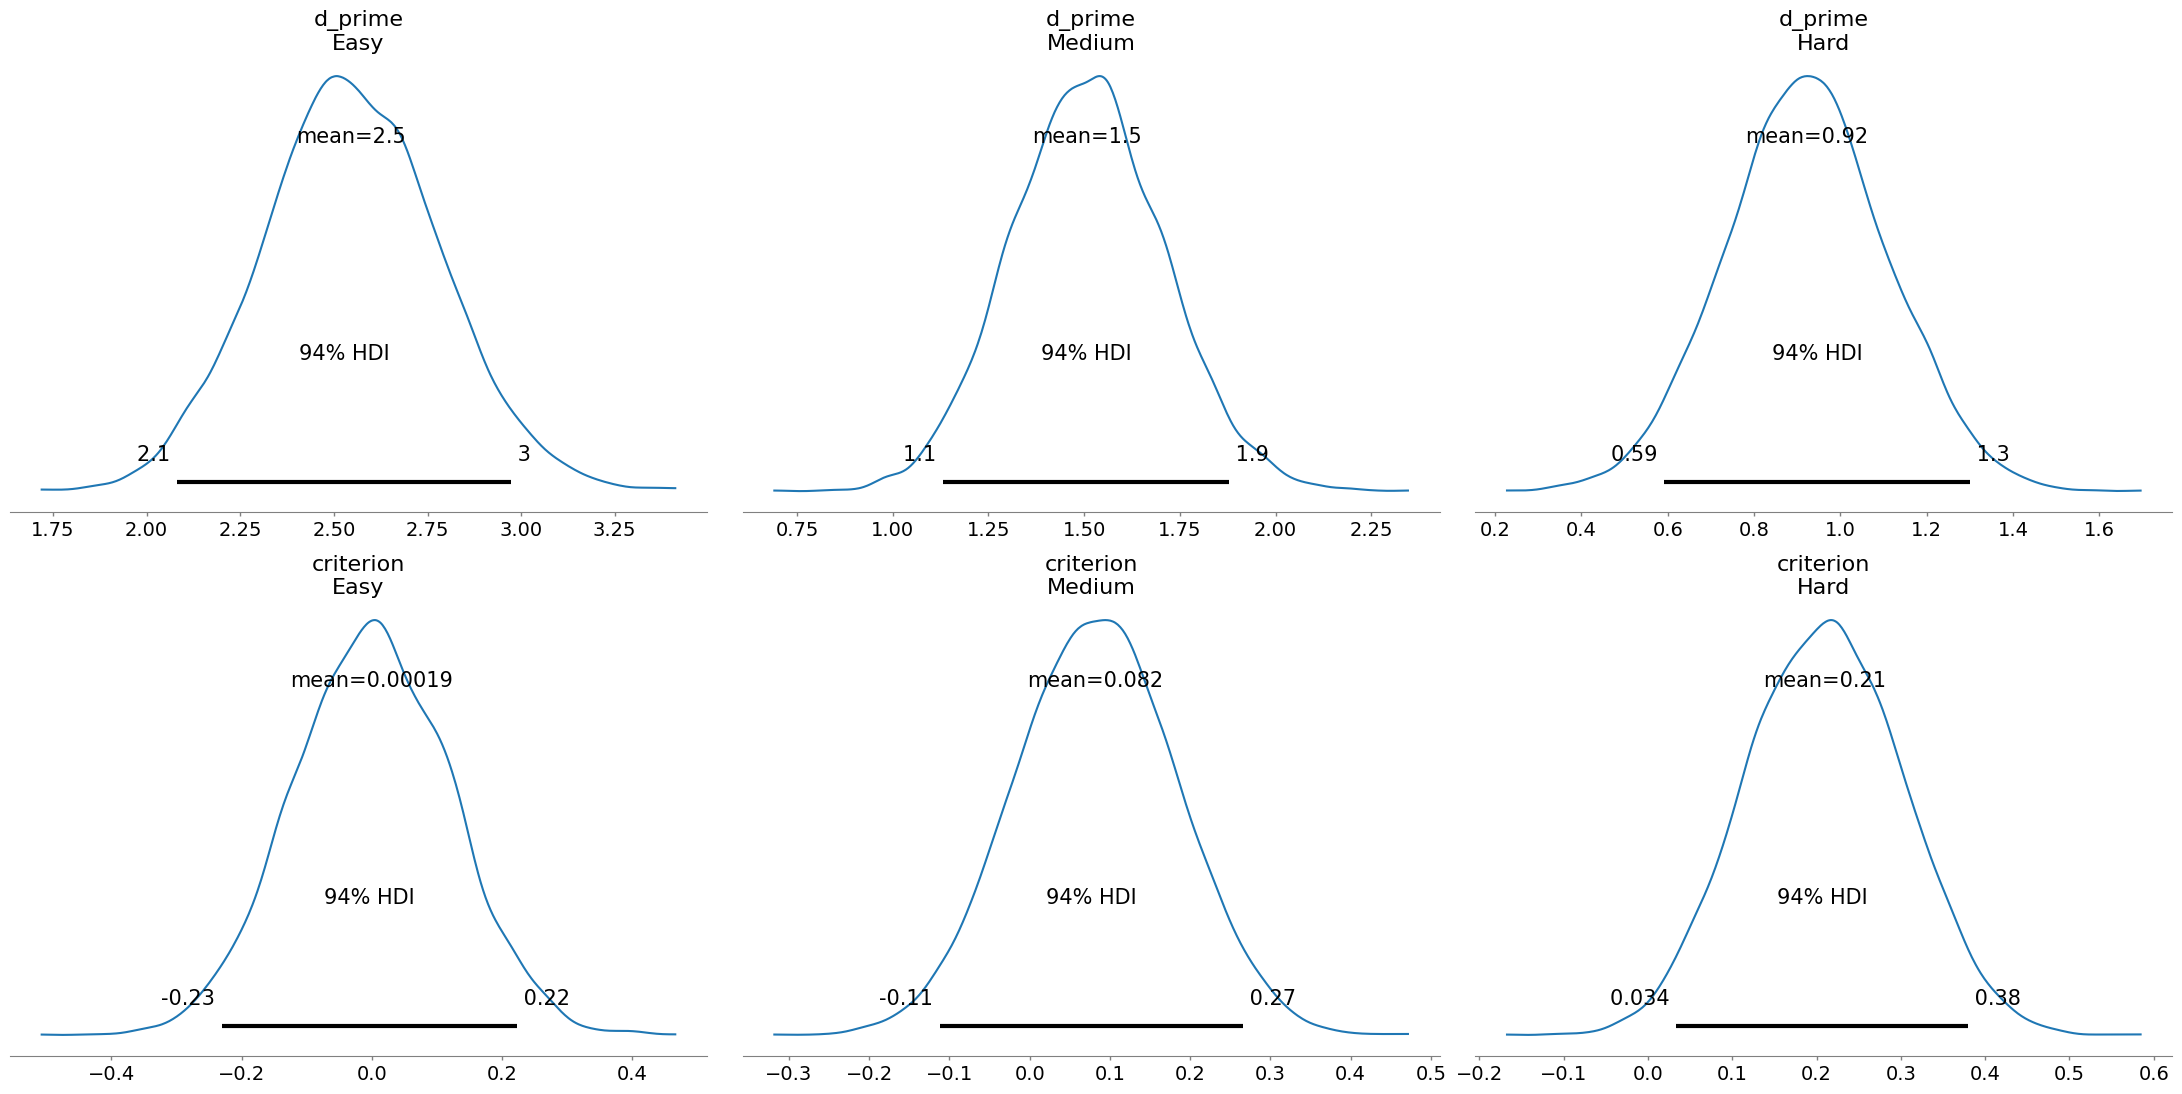

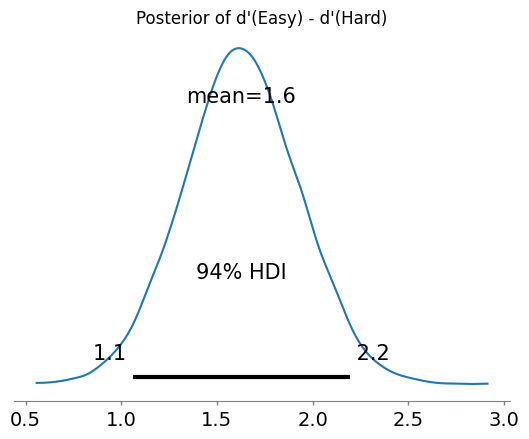


Summary of d' difference (Easy - Hard):
                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
d_prime_diff_Easy_Hard  1.625  0.303   1.063    2.195      0.003    0.003   

                        ess_bulk  ess_tail  r_hat  
d_prime_diff_Easy_Hard   11044.0    6619.0    1.0  


In [39]:
print("\nConditional SDT Model Summary:")
summary_conditional = az.summary(idata_conditional, var_names=['d_prime', 'criterion'], filter_vars="like") # filter_vars="like" shows combined stats if available
print(summary_conditional)

# Plot posteriors for each condition
az.plot_posterior(idata_conditional, var_names=['d_prime', 'criterion'])
plt.tight_layout()
plt.show()

# We can also compare conditions, e.g., difference in d' between Easy and Hard
# Calculate difference within the inference data object
idata_conditional.posterior["d_prime_diff_Easy_Hard"] = (
    idata_conditional.posterior["d_prime"].sel(condition="Easy") -
    idata_conditional.posterior["d_prime"].sel(condition="Hard")
)
az.plot_posterior(idata_conditional, var_names=["d_prime_diff_Easy_Hard"])
plt.title("Posterior of d'(Easy) - d'(Hard)")
plt.show()
summary_diff = az.summary(idata_conditional, var_names=["d_prime_diff_Easy_Hard"])
print("\nSummary of d' difference (Easy - Hard):")
print(summary_diff)





**Interpretation:**

The summary now shows estimates for `d'` and `c` for each condition. We can see how sensitivity and bias change across conditions. Plotting the posterior distributions helps visualize these differences and their associated uncertainty. We can also directly compute and plot the posterior distribution for the *difference* between parameters (like `d'(Easy) - d'(Hard)`), which is often the quantity of interest for comparisons.

---

## Model 3: Hierarchical SDT (P Persons, One Condition)

Often, we collect data from multiple participants (P) performing the same task. A hierarchical model is ideal here. It estimates parameters for each individual participant while assuming these individual parameters are drawn from a group-level distribution. This allows participants' data to inform each other (pooling information / shrinkage), leading to more stable estimates, especially for participants with noisy data.

**3.1 Define Data**

Assume P=20 participants.



In [40]:
# Simulate data for P=20 participants
np.random.seed(123) # for reproducibility
P = 20
# True group parameters (for simulation)
true_mu_d = 1.5
true_sigma_d = 0.5
true_mu_c = 0.2
true_sigma_c = 0.3

# Individual true parameters
true_d_primes = np.random.normal(true_mu_d, true_sigma_d, P)
true_criteria = np.random.normal(true_mu_c, true_sigma_c, P)

# Simulate observed data
n_signal_p = 100 # Assume constant number of trials for simplicity
n_noise_p = 100

true_hr = stats.norm.cdf(true_d_primes / 2 - true_criteria)
true_far = stats.norm.cdf(-true_d_primes / 2 - true_criteria)

# Add binomial noise
hits_p = np.random.binomial(n_signal_p, true_hr)
fas_p = np.random.binomial(n_noise_p, true_far)

# We don't need misses and CRs directly for the model,
# but they are implied:
# misses_p = n_signal_p - hits_p
# crs_p = n_noise_p - fas_p

# Participant IDs
participants = [f"P{i+1}" for i in range(P)]

print(f"Number of participants: {P}")


Number of participants: 20




**3.2 Define the PyMC Model**

The key difference is the introduction of group-level parameters (`mu_d`, `sigma_d`, `mu_c`, `sigma_c`) which act as priors for the individual-level parameters (`d_prime_p`, `criterion_p`).



In [41]:
coords = {"participant": participants}

with pm.Model(coords=coords) as model_hierarchical:
    # --- Group-Level Priors (Hyper-priors) ---
    # Prior for the mean d' across participants
    mu_d = pm.Normal('mu_d', mu=0.0, sigma=2.0)
    # Prior for the standard deviation of d' across participants
    # HalfNormal is common for scale parameters (must be positive)
    sigma_d = pm.HalfNormal('sigma_d', sigma=1.0)

    # Prior for the mean criterion across participants
    mu_c = pm.Normal('mu_c', mu=0.0, sigma=2.0)
    # Prior for the standard deviation of criterion across participants
    sigma_c = pm.HalfNormal('sigma_c', sigma=1.0)

    # --- Individual-Level Parameters ---
    # Individual d' values are drawn from a Normal distribution
    # defined by the group parameters mu_d and sigma_d.
    # Dims links this to participant coordinate.
    d_prime_p = pm.Normal('d_prime_p', mu=mu_d, sigma=sigma_d, dims="participant")

    # Individual criterion values are drawn from a Normal distribution
    # defined by the group parameters mu_c and sigma_c.
    criterion_p = pm.Normal('criterion_p', mu=mu_c, sigma=sigma_c, dims="participant")

    # --- Deterministic Transformations ---
    # Calculate HR and FAR for each participant
    hr_D_p = pm.Deterministic('hr_D_p', Phi(d_prime_p / 2 - criterion_p), dims="participant")
    far_D_p = pm.Deterministic('far_D_p', Phi(-d_prime_p / 2 - criterion_p), dims="participant")

    # --- Likelihood ---
    # Binomial likelihood for each participant's hits and FAs
    # Ensure trial numbers are broadcast correctly if they differ per participant
    # Here we assume they are constant (n_signal_p, n_noise_p)
    H_obs = pm.Binomial('H_obs',
                        n=n_signal_p,      # Can be an array if N varies
                        p=hr_D_p,         # Vector of individual hit rates
                        observed=hits_p,   # Vector of observed hits
                        dims="participant")

    FA_obs = pm.Binomial('FA_obs',
                         n=n_noise_p,     # Can be an array if N varies
                         p=far_D_p,       # Vector of individual FA rates
                         observed=fas_p,  # Vector of observed FAs
                         dims="participant")




**Explanation:**

*   **Hierarchy:** `mu_d`, `sigma_d`, `mu_c`, `sigma_c` are *hyperparameters*. They define the population distribution from which individual parameters (`d_prime_p`, `criterion_p`) are drawn.
*   **Shrinkage:** The model learns both group and individual parameters simultaneously. If a participant's data strongly suggests a parameter value far from the group mean, the estimate will be close to the individual data. If the data is noisy or less informative, the estimate will be "shrunk" towards the group mean.
*   `dims="participant"`: Used again to manage the participant dimension.

**3.3 Run the Sampler**

Hierarchical models can sometimes be harder to sample. Increasing `tune` or `target_accept` might be necessary. Using a *non-centered parameterization* can also help, but we'll stick to the centered one for simplicity here.



In [42]:
with model_hierarchical:
    # Hierarchical models might require more tuning steps or higher target_accept
    idata_hierarchical = pm.sample(draws=2000, tune=2000, chains=4, target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_d, sigma_d, mu_c, sigma_c, d_prime_p, criterion_p]


/home/joachim/Dropbox/Teaching/S25/cogs107/0-introduction/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.




**3.4 Analyze Results**




Hierarchical SDT Model Summary (Group Parameters):
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_d     1.574  0.159   1.280    1.879      0.001    0.002   12758.0   
sigma_d  0.663  0.127   0.443    0.900      0.001    0.002   11746.0   
mu_c     0.127  0.088  -0.043    0.289      0.001    0.001   13136.0   
sigma_c  0.377  0.071   0.255    0.510      0.001    0.001   12195.0   

         ess_tail  r_hat  
mu_d       6574.0    1.0  
sigma_d    6509.0    1.0  
mu_c       6238.0    1.0  
sigma_c    6608.0    1.0  

Hierarchical SDT Model Summary (Example Individual Parameters):
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
d_prime_p[P1]    0.814  0.181   0.475    1.161      0.001    0.002   17886.0   
d_prime_p[P2]    2.105  0.240   1.636    2.541      0.002    0.003   14310.0   
d_prime_p[P3]    1.853  0.199   1.492    2.233      0.001    0.003   18069.0   
criterion_p[P1]  0.387  0.092   0.211    0.558      0.001    0.001 

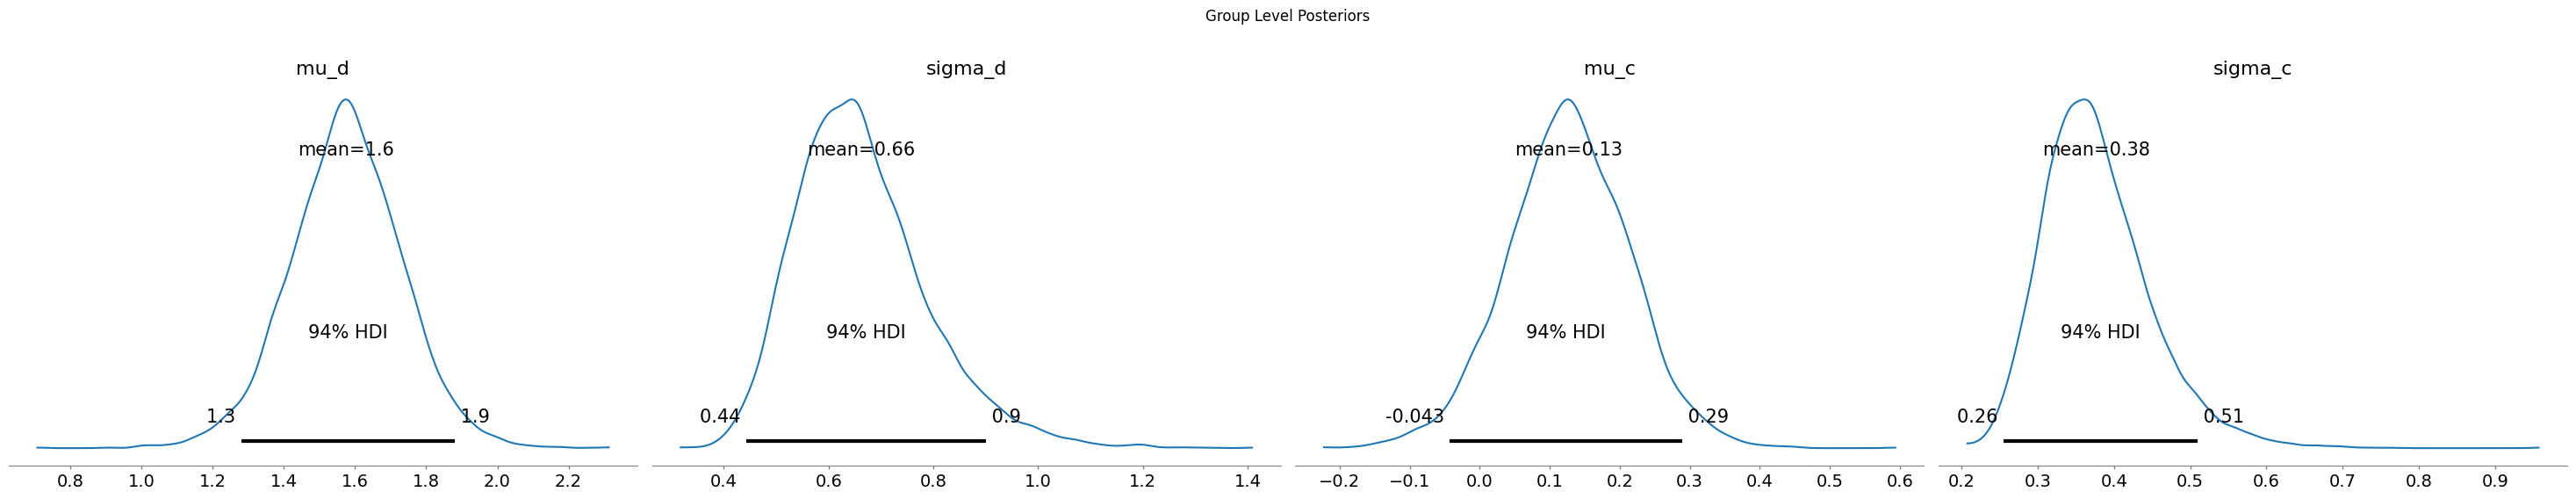

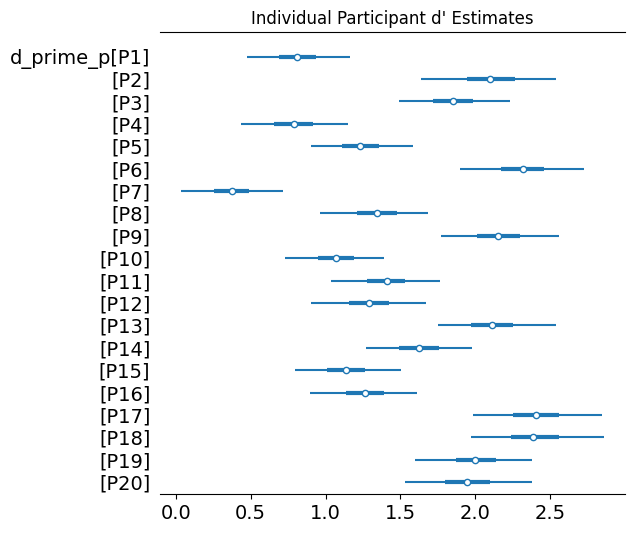

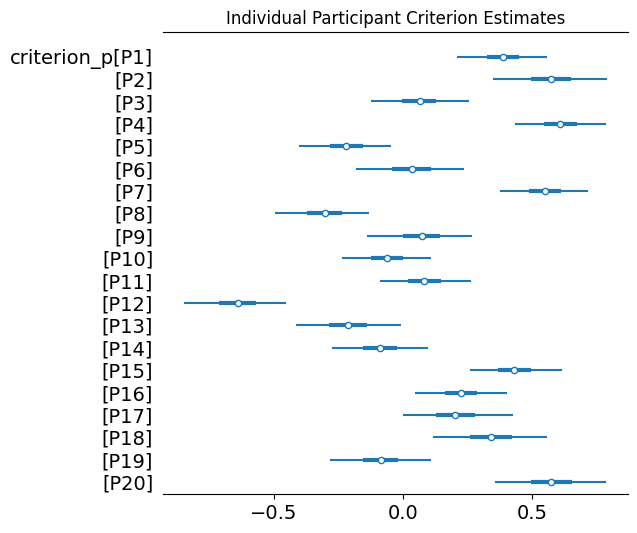

In [43]:
print("\nHierarchical SDT Model Summary (Group Parameters):")
summary_hier_group = az.summary(idata_hierarchical, var_names=['mu_d', 'sigma_d', 'mu_c', 'sigma_c'])
print(summary_hier_group)

print("\nHierarchical SDT Model Summary (Example Individual Parameters):")
# Show summary for a few participants
summary_hier_indiv = az.summary(idata_hierarchical, var_names=['d_prime_p', 'criterion_p'], coords={'participant': ['P1', 'P2', 'P3']})
print(summary_hier_indiv)

# Plot group-level posteriors
az.plot_posterior(idata_hierarchical, var_names=['mu_d', 'sigma_d', 'mu_c', 'sigma_c'])
plt.suptitle("Group Level Posteriors", y=1.02)
plt.tight_layout()
plt.show()

# Plot individual-level posteriors (e.g., for d') - Forest plot is good here
az.plot_forest(idata_hierarchical, var_names=['d_prime_p'], combined=True, hdi_prob=0.94)
plt.title("Individual Participant d' Estimates")
plt.show()

az.plot_forest(idata_hierarchical, var_names=['criterion_p'], combined=True, hdi_prob=0.94)
plt.title("Individual Participant Criterion Estimates")
plt.show()




**Interpretation:**

We get estimates for the overall group tendencies (`mu_d`, `mu_c`) and the variability across participants (`sigma_d`, `sigma_c`). We also get refined estimates for each individual participant's `d'` and `c`, benefiting from the hierarchical structure. Forest plots are excellent for visualizing the individual estimates and their uncertainty relative to the group distribution.

---

## Model 4: Conditional Hierarchical SDT (P Persons, K Conditions)

This is the most comprehensive model, combining hierarchy across participants and conditions within participants. Each participant `p` has parameters (`d'_pk`, `c_pk`) for each condition `k`. These are drawn from group-level distributions that might also vary by condition.

**4.1 Define Data**

We need data structured by participant *and* condition. A P x K structure.



In [44]:
# Simulate data for P=20 participants across K=3 conditions
np.random.seed(456)
P = 20
conditions = ['Easy', 'Medium', 'Hard']
K = len(conditions)

# True group parameters PER CONDITION
# Let's assume d' decreases and |c| increases with difficulty
true_mu_d_k = np.array([2.5, 1.5, 0.8]) # Group mean d' for Easy, Medium, Hard
true_sigma_d_k = np.array([0.4, 0.5, 0.6]) # Group SD d'

true_mu_c_k = np.array([-0.1, 0.1, 0.3]) # Group mean c
true_sigma_c_k = np.array([0.2, 0.3, 0.4]) # Group SD c

# Individual true parameters (shape P x K)
true_d_primes_pk = np.zeros((P, K))
true_criteria_pk = np.zeros((P, K))
for k in range(K):
    true_d_primes_pk[:, k] = np.random.normal(true_mu_d_k[k], true_sigma_d_k[k], P)
    true_criteria_pk[:, k] = np.random.normal(true_mu_c_k[k], true_sigma_c_k[k], P)

# Simulate observed data
n_signal_pk = 100 # Assume constant trials per participant per condition
n_noise_pk = 100

true_hr_pk = stats.norm.cdf(true_d_primes_pk / 2 - true_criteria_pk)
true_far_pk = stats.norm.cdf(-true_d_primes_pk / 2 - true_criteria_pk)

# Add binomial noise
hits_pk = np.random.binomial(n_signal_pk, true_hr_pk) # Shape P x K
fas_pk = np.random.binomial(n_noise_pk, true_far_pk)   # Shape P x K

# Participant and condition IDs
participants = [f"P{i+1}" for i in range(P)]

print(f"Number of participants: {P}")
print(f"Conditions: {conditions}")
print(f"Data shape (hits, FAs): {hits_pk.shape}") # Should be P x K


Number of participants: 20
Conditions: ['Easy', 'Medium', 'Hard']
Data shape (hits, FAs): (20, 3)




**4.2 Define the PyMC Model**

We now have group-level parameters for *each condition*, and individual parameters for each participant *in each condition*. We need two dimensions in our coordinates: `participant` and `condition`.



In [45]:
coords = {
    "participant": participants,
    "condition": conditions
}

# Reshape data for PyMC likelihood (needs to match dims)
# ArviZ works best if observed data has named dimensions matching coords
# We can provide data as DataFrames or xarrays, or ensure numpy arrays align
# with the order of dims specified in the likelihood.
# Here, hits_pk and fas_pk are already in (participant, condition) order.

with pm.Model(coords=coords) as model_cond_hier:
    # --- Group-Level Priors (per condition) ---
    # Shape K (one value per condition)
    mu_d_k = pm.Normal('mu_d_k', mu=0.0, sigma=2.0, dims="condition")
    sigma_d_k = pm.HalfNormal('sigma_d_k', sigma=1.0, dims="condition")
    mu_c_k = pm.Normal('mu_c_k', mu=0.0, sigma=2.0, dims="condition")
    sigma_c_k = pm.HalfNormal('sigma_c_k', sigma=1.0, dims="condition")

    # --- Individual-Level Parameters (per participant, per condition) ---
    # Shape (P, K)
    # Individual d' values are drawn from the condition-specific group distribution
    # PyMC handles the broadcasting: mu_d_k (shape K) and sigma_d_k (shape K)
    # define the distribution for d_prime_pk (shape P, K)
    d_prime_pk = pm.Normal('d_prime_pk', mu=mu_d_k, sigma=sigma_d_k, dims=("participant", "condition"))
    criterion_pk = pm.Normal('criterion_pk', mu=mu_c_k, sigma=sigma_c_k, dims=("participant", "condition"))

    # --- Deterministic Transformations ---
    # Calculate HR and FAR for each participant in each condition
    # Shape (P, K)
    hr_D_pk = pm.Deterministic('hr_D_pk', Phi(d_prime_pk / 2 - criterion_pk), dims=("participant", "condition"))
    far_D_pk = pm.Deterministic('far_D_pk', Phi(-d_prime_pk / 2 - criterion_pk), dims=("participant", "condition"))

    # --- Likelihood ---
    # Binomial likelihood for each participant's hits and FAs in each condition
    # Shape (P, K)
    H_obs = pm.Binomial('H_obs',
                        n=n_signal_pk,          # Can be P x K array if N varies
                        p=hr_D_pk,             # Matrix of individual hit rates
                        observed=hits_pk,       # Matrix of observed hits
                        dims=("participant", "condition")) # Match dims order to observed data

    FA_obs = pm.Binomial('FA_obs',
                         n=n_noise_pk,          # Can be P x K array if N varies
                         p=far_D_pk,            # Matrix of individual FA rates
                         observed=fas_pk,        # Matrix of observed FAs
                         dims=("participant", "condition")) # Match dims order to observed data




**Explanation:**

*   **Two Dimensions:** We now use `dims=("participant", "condition")` for individual-level parameters and the likelihood, reflecting the structure of the data.
*   **Condition-Specific Group Parameters:** `mu_d_k`, `sigma_d_k`, etc., now have `dims="condition"`, meaning we estimate separate group means and standard deviations for each condition.
*   **Broadcasting:** When defining `d_prime_pk` and `criterion_pk`, the `mu` and `sigma` arguments (`mu_d_k`, `sigma_d_k`, etc.) have shape K. PyMC automatically broadcasts these so that for each participant `p` and condition `k`, the parameter `d_prime_pk` is drawn from `Normal(mu=mu_d_k[k], sigma=sigma_d_k[k])`.

**4.3 Run the Sampler**

This is the most complex model and might require careful tuning or non-centered parameterization if divergences occur.



In [46]:
with model_cond_hier:
    # This model is more complex and may benefit from more tuning or higher target_accept
    idata_cond_hier = pm.sample(draws=2000, tune=2500, chains=4, target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_d_k, sigma_d_k, mu_c_k, sigma_c_k, d_prime_pk, criterion_pk]


/home/joachim/Dropbox/Teaching/S25/cogs107/0-introduction/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 7 seconds.




**4.4 Analyze Results**




Conditional Hierarchical SDT Model Summary (Group Parameters per Condition):
                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_d_k[Easy]       2.475  0.123   2.248    2.719      0.002    0.001   
mu_d_k[Medium]     1.432  0.109   1.228    1.638      0.001    0.001   
mu_d_k[Hard]       0.951  0.147   0.686    1.240      0.002    0.002   
sigma_d_k[Easy]    0.474  0.105   0.298    0.681      0.001    0.001   
sigma_d_k[Medium]  0.420  0.093   0.255    0.593      0.001    0.001   
sigma_d_k[Hard]    0.620  0.123   0.410    0.856      0.002    0.002   
mu_c_k[Easy]      -0.113  0.052  -0.205   -0.014      0.001    0.001   
mu_c_k[Medium]     0.170  0.057   0.066    0.278      0.001    0.001   
mu_c_k[Hard]       0.376  0.119   0.148    0.595      0.001    0.001   
sigma_c_k[Easy]    0.190  0.047   0.109    0.278      0.001    0.001   
sigma_c_k[Medium]  0.228  0.048   0.147    0.319      0.001    0.001   
sigma_c_k[Hard]    0.510  0.094   0.354    0.694      0.00

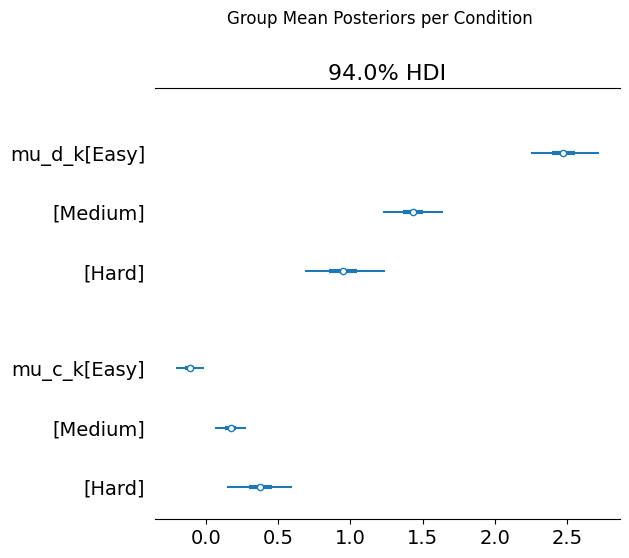

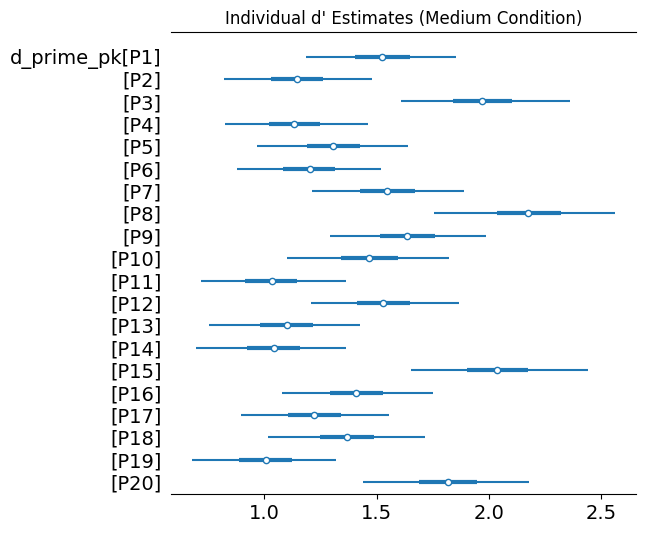

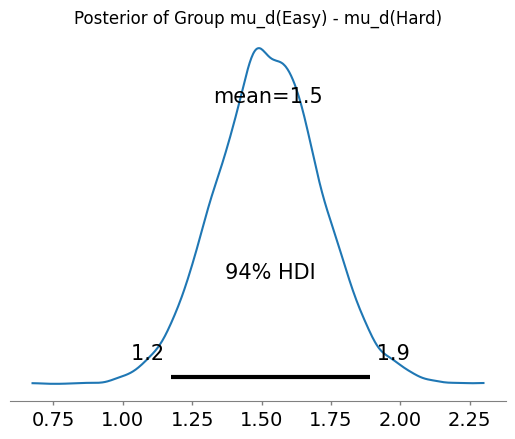


Summary of Group mu_d difference (Easy - Hard):
                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_d_diff_Easy_Hard  1.524  0.192   1.174    1.889      0.002    0.002   

                     ess_bulk  ess_tail  r_hat  
mu_d_diff_Easy_Hard    7013.0    5889.0    1.0  


In [47]:
print("\nConditional Hierarchical SDT Model Summary (Group Parameters per Condition):")
summary_cond_hier_group = az.summary(idata_cond_hier, var_names=['mu_d_k', 'sigma_d_k', 'mu_c_k', 'sigma_c_k'])
print(summary_cond_hier_group)

print("\nConditional Hierarchical SDT Model Summary (Example Individual Parameters, Condition 'Easy'):")
# Filter summary by coordinate value
summary_cond_hier_indiv = az.summary(idata_cond_hier, var_names=['d_prime_pk', 'criterion_pk'], coords={'condition': ['Easy'], 'participant': ['P1', 'P2']})
print(summary_cond_hier_indiv)


# Plot group-level posteriors per condition
az.plot_forest(idata_cond_hier, var_names=['mu_d_k', 'mu_c_k'], combined=True, hdi_prob=0.94)
plt.suptitle("Group Mean Posteriors per Condition", y=1.02)
plt.show()

# Plot individual estimates for a specific condition (e.g., 'Medium')
az.plot_forest(idata_cond_hier,
                var_names=['d_prime_pk'],
                coords={'condition': 'Medium'}, # Select condition
                combined=True, hdi_prob=0.94)
plt.title("Individual d' Estimates (Medium Condition)")
plt.show()

# Compare conditions at the group level
# Example: Difference in group mean d' between Easy and Hard
idata_cond_hier.posterior["mu_d_diff_Easy_Hard"] = (
    idata_cond_hier.posterior["mu_d_k"].sel(condition="Easy") -
    idata_cond_hier.posterior["mu_d_k"].sel(condition="Hard")
)
az.plot_posterior(idata_cond_hier, var_names=["mu_d_diff_Easy_Hard"])
plt.title("Posterior of Group mu_d(Easy) - mu_d(Hard)")
plt.show()
summary_group_diff = az.summary(idata_cond_hier, var_names=["mu_d_diff_Easy_Hard"])
print("\nSummary of Group mu_d difference (Easy - Hard):")
print(summary_group_diff)




**Interpretation:**

This model provides the richest picture:
*   Group-level understanding of how sensitivity (`mu_d_k`) and bias (`mu_c_k`) change across conditions on average.
*   Group-level understanding of individual differences within each condition (`sigma_d_k`, `sigma_c_k`).
*   Individual-level estimates (`d_prime_pk`, `criterion_pk`) for each participant in each condition, informed by both their own data and the group trends (shrinkage).
*   Ability to formally compare conditions at the group level (e.g., is `mu_d` significantly higher in the 'Easy' condition than the 'Hard' condition?).

---

**Conclusion**

This guide demonstrated how to progressively build SDT models in PyMC, from a basic single-subject/single-condition case to a full conditional hierarchical model. Key PyMC concepts used include:

*   Defining priors (`pm.Normal`, `pm.HalfNormal`).
*   Calculating deterministic quantities (`pm.Deterministic`, `pm.math`).
*   Defining the likelihood (`pm.Binomial`).
*   Using coordinates (`coords`, `dims`) for multi-dimensional data (conditions, participants).
*   Implementing hierarchical structures by defining group-level parameters (hyperparameters) that inform individual-level parameter priors.
*   Sampling from the posterior (`pm.sample`).
*   Analyzing and visualizing results (`az.summary`, `az.plot_trace`, `az.plot_posterior`, `az.plot_forest`).

These building blocks allow you to adapt SDT models to various experimental designs and research questions within the flexible Bayesian framework provided by PyMC. Remember that choosing appropriate priors and checking MCMC convergence are crucial steps in any Bayesian analysis.